# <div align='center' style='font-size:35px;color:#336699;'>Image Scaling Attacks on Machine Learning Algorithms:   Defenses💻</div>

Install required libraries.

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

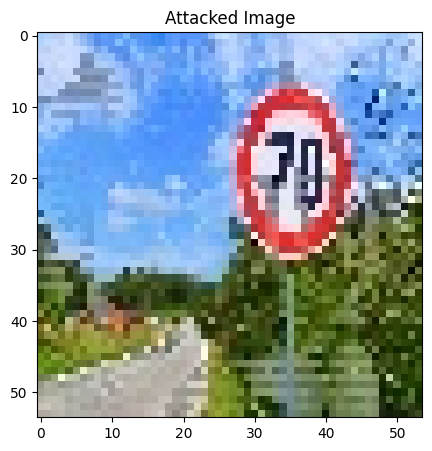

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


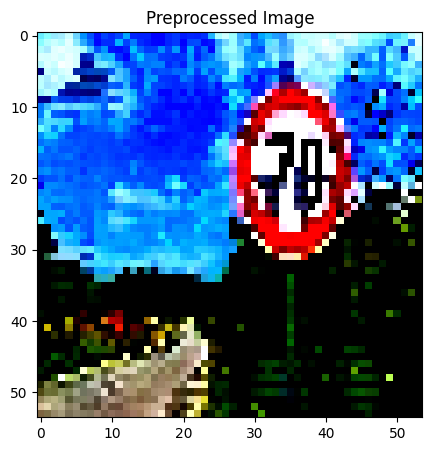

1/1 [==============================] - 0s 392ms/step


C:\Users\dell\AppData\Local\Temp\ipykernel_12504\2822793219.py:49: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_index = ssim(image.squeeze(), resized_back_image, multichannel=True)
C:\Users\dell\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean difference: 0.13192973177079403, SSIM index: 0.9125148147557772
Attack detected!


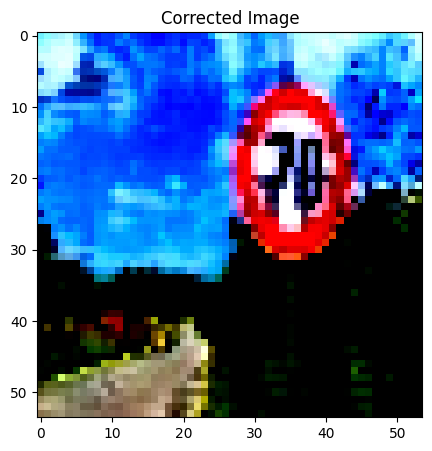

1/1 [==============================] - 0s 59ms/step
The model classifies the attacked image as class 33 (Turn right ahead).
The model classifies the corrected image as class 5 (Speed limit (80km/h)).


In [1]:
# Define image loader
def imgLoader(imgPath, color_flag=cv2.IMREAD_COLOR):
    try:
        img = cv2.imread(imgPath, color_flag)
        if img is None:
            raise FileNotFoundError(f"Fail to load the image {imgPath}")
        height, width, *channel = img.shape
        if not channel:
            img = img.reshape((height, width, 1))
        return img
    except Exception as e:
        print(e)
        return None

# Define image saver
def imgSaver(imgPath, img):
    try:
        cv2.imwrite(imgPath, img)
    except Exception as e:
        print(f'Fail to save the image as {imgPath}: {e}')

# Define preprocessing function
def preprocess_image(image):
    # Normalize the image
    image = (image - np.mean(image)) / np.std(image)
    return image

# Improved detection function using pixel-wise comparison and structural similarity
def detect_attack(image, threshold_diff=0.1, threshold_ssim=0.95):
    original_shape = image.shape
    scaled_image = tf.image.resize(image, [original_shape[0] * 2, original_shape[1] * 2])
    resized_back_image = tf.image.resize(scaled_image, original_shape[:2])
    resized_back_image = resized_back_image.numpy().squeeze()

    # Compute the pixel-wise difference
    difference = np.abs(resized_back_image - image)
    mean_diff = np.mean(difference)
    
    # Compute Structural Similarity Index (SSI)
    ssim_index = ssim(image.squeeze(), resized_back_image, multichannel=True)

    print(f'Mean difference: {mean_diff}, SSIM index: {ssim_index}')

    # Check if the mean difference or SSIM index exceeds the threshold
    if mean_diff > threshold_diff or ssim_index < threshold_ssim:
        return True
    return False

# Define prevention function
def prevent_attack(image):
    # Resize the image back to its original shape
    original_shape = image.shape
    scaled_image = tf.image.resize(image, [original_shape[0] * 2, original_shape[1] * 2])
    restored_image = tf.image.resize(scaled_image, original_shape[:2])
    return restored_image.numpy()

# Load the attacked image
attack_img_path = 'attacked images/L2 Cubic (Output) .jpg'
attacked_image = imgLoader(attack_img_path)

if attacked_image is None:
    raise FileNotFoundError(f"Fail to load the image {attack_img_path}")

attacked_image = cv2.cvtColor(attacked_image, cv2.COLOR_BGR2RGB)

# Display the attacked image
plt.figure(figsize=(5, 5))
plt.title('Attacked Image')
plt.imshow(attacked_image)
plt.show()

# Preprocess the image
preprocessed_image = preprocess_image(attacked_image)

# Display the preprocessed image
plt.figure(figsize=(5, 5))
plt.title('Preprocessed Image')
plt.imshow(preprocessed_image.squeeze(), cmap='gray')
plt.show()

# Load the model
model_path = 'GTSRB_model.keras'
model = load_model(model_path)

# Prepare the attacked image for prediction
attacked_image_resized = cv2.resize(attacked_image, (model.input_shape[1], model.input_shape[2]))
attacked_image_resized = attacked_image_resized.astype('float32') / 255.0
attacked_image_resized = np.expand_dims(attacked_image_resized, axis=0)

# Predict with the model
attacked_pred = model.predict(attacked_image_resized)
attacked_class = np.argmax(attacked_pred)

# Detect if the image is under attack
is_attack = detect_attack(preprocessed_image)
if is_attack:
    print('Attack detected!')
else:
    print('No attack detected.')

# Prevent the attack
if is_attack:
    corrected_image = prevent_attack(preprocessed_image)
    
    # Display the corrected image
    plt.figure(figsize=(5, 5))
    plt.title('Corrected Image')
    plt.imshow(corrected_image.squeeze(), cmap='gray')
    plt.show()
else:
    corrected_image = preprocessed_image

# Prepare the corrected image for prediction
corrected_image_resized = cv2.resize(corrected_image.squeeze(), (model.input_shape[1], model.input_shape[2]))
corrected_image_resized = corrected_image_resized.astype('float32') / 255.0
corrected_image_resized = np.expand_dims(corrected_image_resized, axis=0)

# Predict with the model
corrected_pred = model.predict(corrected_image_resized)
corrected_class = np.argmax(corrected_pred)

class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

print(f"The model classifies the attacked image as class {attacked_class} ({class_names[attacked_class]}).")
print(f"The model classifies the corrected image as class {corrected_class} ({class_names[corrected_class]}).")

1/1 [==============================] - 0s 62ms/step


C:\Users\dell\AppData\Local\Temp\ipykernel_12504\3392643927.py:49: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_index = ssim(image.squeeze(), resized_back_image, multichannel=True)


Mean difference: 0.03496248023788902, SSIM index: 0.9737878356252506
No attack detected.
1/1 [==============================] - 0s 32ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


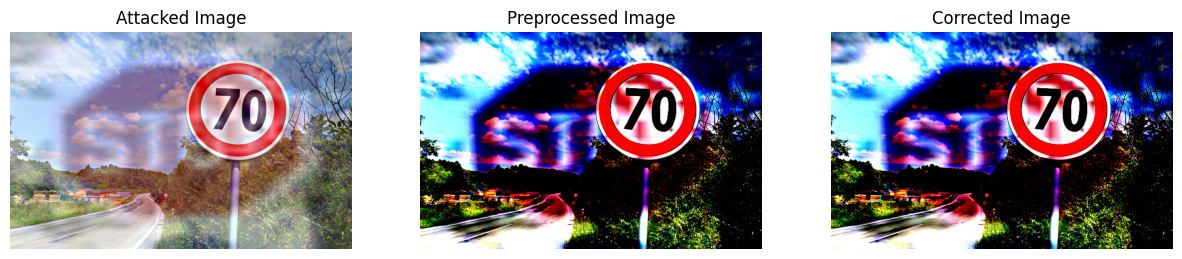

The model classifies the attacked image as class 14 (Stop).
The model classifies the corrected image as class 5 (Speed limit (70km/h)).


In [7]:
# Define image loader
def imgLoader(imgPath, color_flag=cv2.IMREAD_COLOR):
    try:
        img = cv2.imread(imgPath, color_flag)
        if img is None:
            raise FileNotFoundError(f"Fail to load the image {imgPath}")
        height, width, *channel = img.shape
        if not channel:
            img = img.reshape((height, width, 1))
        return img
    except Exception as e:
        print(e)
        return None

# Define image saver
def imgSaver(imgPath, img):
    try:
        cv2.imwrite(imgPath, img)
    except Exception as e:
        print(f'Fail to save the image as {imgPath}: {e}')

# Define preprocessing function
def preprocess_image(image):
    # Normalize the image
    image = (image - np.mean(image)) / np.std(image)
    return image

# Improved detection function using pixel-wise comparison and structural similarity
def detect_attack(image, threshold_diff=0.1, threshold_ssim=0.95):
    original_shape = image.shape
    scaled_image = tf.image.resize(image, [original_shape[0] * 2, original_shape[1] * 2])
    resized_back_image = tf.image.resize(scaled_image, original_shape[:2])
    resized_back_image = resized_back_image.numpy().squeeze()

    # Compute the pixel-wise difference
    difference = np.abs(resized_back_image - image)
    mean_diff = np.mean(difference)
    
    # Compute Structural Similarity Index (SSI)
    ssim_index = ssim(image.squeeze(), resized_back_image, multichannel=True)

    print(f'Mean difference: {mean_diff}, SSIM index: {ssim_index}')

    # Check if the mean difference or SSIM index exceeds the threshold
    if mean_diff > threshold_diff or ssim_index < threshold_ssim:
        return True
    return False

# Define prevention function
def prevent_attack(image):
    # Resize the image back to its original shape
    original_shape = image.shape
    scaled_image = tf.image.resize(image, [original_shape[0] * 2, original_shape[1] * 2])
    restored_image = tf.image.resize(scaled_image, original_shape[:2])
    return restored_image.numpy()

# Load the attacked image
attack_img_path = 'attacked_image.png'
attacked_image = imgLoader(attack_img_path)

if attacked_image is None:
    raise FileNotFoundError(f"Fail to load the image {attack_img_path}")

attacked_image = cv2.cvtColor(attacked_image, cv2.COLOR_BGR2RGB)

# Preprocess the image
preprocessed_image = preprocess_image(attacked_image)

# Load the model
model_path = 'GTSRB_model.keras'
model = load_model(model_path)

# Prepare the attacked image for prediction
attacked_image_resized = cv2.resize(attacked_image, (model.input_shape[1], model.input_shape[2]))
attacked_image_resized = attacked_image_resized.astype('float32') / 255.0
attacked_image_resized = np.expand_dims(attacked_image_resized, axis=0)

# Predict with the model
attacked_pred = model.predict(attacked_image_resized)
attacked_class = np.argmax(attacked_pred)

# Detect if the image is under attack
is_attack = detect_attack(preprocessed_image)
if is_attack:
    print('Attack detected!')
    corrected_image = prevent_attack(preprocessed_image)
else:
    print('No attack detected.')
    corrected_image = preprocessed_image

# Prepare the corrected image for prediction
corrected_image_resized = cv2.resize(corrected_image.squeeze(), (model.input_shape[1], model.input_shape[2]))
corrected_image_resized = corrected_image_resized.astype('float32') / 255.0
corrected_image_resized = np.expand_dims(corrected_image_resized, axis=0)

# Predict with the model
corrected_pred = model.predict(corrected_image_resized)
corrected_class = np.argmax(corrected_pred)

class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (80km/h)',
    5: 'Speed limit (70km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

# Display the images side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(attacked_image)
axs[0].set_title('Attacked Image')
axs[0].axis('off')

axs[1].imshow(preprocessed_image.squeeze(), cmap='gray')
axs[1].set_title('Preprocessed Image')
axs[1].axis('off')

axs[2].imshow(corrected_image.squeeze(), cmap='gray')
axs[2].set_title('Corrected Image')
axs[2].axis('off')

plt.show()

print(f"The model classifies the attacked image as class {attacked_class} ({class_names[attacked_class]}).")
print(f"The model classifies the corrected image as class {corrected_class} ({class_names[corrected_class]}).")